테스트할 이미지를 업로드해주세요.


Saving Rubber_Soul.png to Rubber_Soul (5).png

[테스트 1] 원본 크기로 탐지 (리사이즈 안 함, 민감도 0.6)
4개의 얼굴을 찾았습니다.


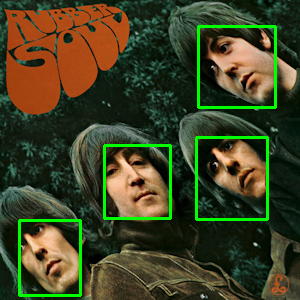


[테스트 2] 표준 크기로 탐지 (리사이즈 적용(고화질 사진에 유리), 민감도 0.6)
4개의 얼굴을 찾았습니다.


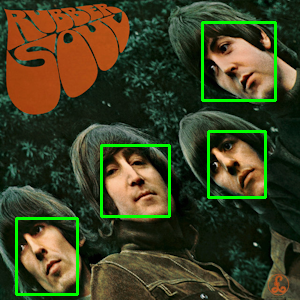

In [43]:
import cv2
import numpy as np
import os
from google.colab import files
from google.colab.patches import cv2_imshow

# --- 최종 얼굴 탐지 및 잘라내기 함수 (수정 없음) ---
def detect_and_crop_faces(image_path, score_threshold=0.9, target_size=None):
    """
    이미지에서 얼굴을 탐지하고 잘라냅니다.

    Args:
        image_path (str): 분석할 이미지 파일 경로
        score_threshold (float): 얼굴로 판단할 최소 신뢰도 점수
        target_size (int, optional): 이미지 리사이즈 목표 크기. None이면 리사이즈 안 함.

    Returns:
        tuple: (잘라낸 얼굴 이미지 리스트, 결과가 그려진 이미지)
    """
    # 1. 모델 로드
    model_file = 'face_detection_yunet_2023mar.onnx'
    if not os.path.exists(model_file):
        !wget -q https://github.com/opencv/opencv_zoo/raw/main/models/face_detection_yunet/{model_file}

    # 2. 이미지 로드
    img = cv2.imread(image_path)
    if img is None:
        print(f"오류: '{image_path}' 파일을 불러올 수 없습니다.")
        return [], None

    # 3. (선택적) 이미지 리사이즈
    if target_size is not None:
        original_h, original_w, _ = img.shape
        if original_h > original_w:
            new_h, new_w = target_size, int(original_w * target_size / original_h)
        else:
            new_h, new_w = int(original_h * target_size / original_w), target_size

        img_for_detection = cv2.resize(img, (new_w, new_h))
    else:
        img_for_detection = img.copy()

    # 4. 얼굴 탐지
    h, w, _ = img_for_detection.shape
    detector = cv2.FaceDetectorYN.create(model_file, "", (0, 0))
    detector.setInputSize((w, h))
    detector.setScoreThreshold(score_threshold)
    faces = detector.detect(img_for_detection)

    # 5. 결과 처리 및 잘라내기
    cropped_faces = []
    img_with_boxes = img.copy() # 원본에 박스를 그리기 위함

    if faces[1] is not None:
        for face in faces[1]:
            box = face[0:4].astype(np.int32)

            # 리사이즈 여부에 따라 원본 좌표 계산
            if target_size is not None:
                scale_w = original_w / new_w
                scale_h = original_h / new_h
                x = int(box[0] * scale_w)
                y = int(box[1] * scale_h)
                width = int(box[2] * scale_w)
                height = int(box[3] * scale_h)
            else:
                x, y, width, height = box[0], box[1], box[2], box[3]

            # 원본 이미지에 박스 그리기
            cv2.rectangle(img_with_boxes, (x, y), (x + width, y + height), (0, 255, 0), 2)
            # 원본 이미지에서 잘라내기
            cropped_faces.append(img[y : y + height, x : x + width])

    return cropped_faces, img_with_boxes

# --- [수정된 부분] 범용 함수 사용 예시 ---
print("테스트할 이미지를 업로드해주세요.")
uploaded = files.upload()

score_threshold = 0.6

if len(uploaded.keys()) > 0:
    file_name = list(uploaded.keys())[0]

    print("\n" + "="*50)
    print(f'[테스트 1] 원본 크기로 탐지 (리사이즈 안 함, 민감도 {score_threshold})')
    cropped_1, result_img_1 = detect_and_crop_faces(file_name, score_threshold, target_size=None)
    if result_img_1 is not None:
      print(f"{len(cropped_1)}개의 얼굴을 찾았습니다.")
      cv2_imshow(result_img_1)

    print("\n" + "="*50)
    print(f'[테스트 2] 표준 크기로 탐지 (리사이즈 적용(고화질 사진에 유리), 민감도 {score_threshold})')
    cropped_2, result_img_2 = detect_and_crop_faces(file_name, score_threshold, target_size=640)
    if result_img_2 is not None:
      print(f"{len(cropped_2)}개의 얼굴을 찾았습니다.")
      cv2_imshow(result_img_2)